# 605.649 — Introduction to Machine Learning
##  Programming Project 5  
## Neural Net  (Classification)

The purpose of this assignment is to give you experience developing one of the main algorithms for training feedforward neural networks—backpropagation. In this project, you will evaluate the performance of a feedforward network trained with backprop. For this assignment, you will use six datasets (three classification and three regression), all of which you have used in prior assignments. You will download these data sets from the UCI Machine Learning Repository or directly from Blackboard, namely:
1. Breast Cancer [Classification]
https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Original%29
This breast cancer databases was obtained from the University of Wisconsin Hospitals, Madison from
Dr. William H. Wolberg.
2. Glass [Classification]
https://archive.ics.uci.edu/ml/datasets/Glass+Identification
The study of classification of types of glass was motivated by criminological investigation.
3. Soybean (small) [Classification]
https://archive.ics.uci.edu/ml/datasets/Soybean+%28Small%29
A small subset of the original soybean database.
4. Abalone [Regression]
https://archive.ics.uci.edu/ml/datasets/Abalone
Predicting the age of abalone from physical measurements.
5. Computer Hardware [Regression]
https://archive.ics.uci.edu/ml/datasets/Computer+Hardware
The estimated relative performance values were estimated by the authors using a linear regression method. The gives you a chance to see how well you can replicate the results with these two models.
6. Forest Fires [Regression]
https://archive.ics.uci.edu/ml/datasets/Forest+Fires
This is a difficult regression task, where the aim is to predict the burned area of forest fires, in the northeast region of Portugal, by using meteorological and other data .
When using these data sets, be careful of some issues.
1. Some of the data sets have missing attribute values, which is usually indicated by “?”. When this occurs in low numbers, you may simply edit the corresponding data items out of the data sets. For more occurrences, you should do some kind of “data imputation” where, basically, you generate a value of some kind. A naïve approach is to impute the missing value with a random number or the attribute’s mean (or median). A better approach is to sample according to the conditional probability of the values occurring, given the underlying class for that example. The choice of strategy is yours, but be sure to document your choice.
2. For networks with multiple outputs, you should use what is called a “multi-net.” This is where you train a single network with multiple outputs, one for each outcome you need to predict. This is distinct from training separate networks for each output, which is effectively what you have done with prior linear models.
3. The attributes should not require any special handling with either model. It is highly recommended that you normalize numerical attributes first to be in the range −1 to +1 or by using z-score normalization (i.e., z = (x − µ)/σ) and apply the inputs directly.
4. You will need to determine the number of hidden nodes per layer via a tuning process. Note that you can use a rule of thumb that you have fewer hidden nodes than inputs, but be careful that this may not always work. In addition, when you go to two hidden layers, you should not need as many hidden nodes per layer as you needed in the one hidden layer case. For this project, the following steps are required:
- Download the six (6) data sets from the UCI Machine Learning repository. You can find this repository at http://archive.ics.uci.edu/ml/. You can also obtain them directly in Blackboard. All of the specific URLs are also provided above.
- Pre-process each data set as necessary to handle missing data and normalize as needed.
- Implement backpropagation for training feedforward neural networks. You may choose to use either the logistic activation function or the hyperbolic tangent activation function. Do not use ReLU or other similar activation functions. For regression, you should use a linear output. Remember that these choices affect the update rules because of having different derivatives. It is also your choice whether or not you use momentum.
- Remember that you have a number of items to tune, including nodes per layer, learning rate, momentum (if you choose to use it), stopping threshold or number of iterations, etc. Be sure to use the tuning strategy described in earlier assignments.
- Run your algorithms on each of the data sets. These runs should be done with 5-fold cross-validation so you can compare your results statistically. You can use classification error or mean squared error (as appropriate) for your loss function.
- Run your feedforward network trained with backpropagation on each of the data sets. These runs should output the classifications on all of the test examples. If you are doing cross-validation, just output classifications for one fold each. Run your experiments with no hidden layers, one hidden layer, and two hidden layers. It is up to you to tune the number of hidden nodes per layer, and be sure to explain how you did the tuning.

- For the video, the following constitute minimal requirements that must be satisfied:
- Provide sample outputs from one test set showing performance on your feedforward networks. Show results for each of the cases where you have no hidden layers, one hidden layer, and two hidden layers.
- Show a sample model for the smallest of each of your three neural network types (i.e., zero hidden layer, one hidden layer, two hidden layers). This will consist of showing the weight matrices with the inputs/outputs of the layer labeled in some way.
- Demonstrate and explain how an example is propagated through a two hidden layer network. Be sure to show the activations at each layer being calculated correctly.
- Demonstrate the weight updates occurring on a two-layer network for each of the layers.
- Demonstrate the gradient calculation at the output for any one of your networks.
- Show the average performance over the five folds for one of the data sets for each of the three types of networks (i.e., zero hidden layer, one hidden layer, two hidden layers


In [1]:
# Importing Libraries
%matplotlib inline
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import copy
from numpy import array, newaxis, expand_dims

# Loading Data and Preprocessing

### Helper Functions

In [2]:
def str_to_int(df, col_indx):
    """
    Function to convert string value to unique integers **in place** and return dictionary 
    Input: df :pd.DataFrame
           col_index: column index
    output: dictionary: dict to map str : int
    """
    col = df[col_indx]
    row = len(col)
    keys = pd.unique(df[col_indx])
    dictionary = dict(zip(keys, np.linspace(0,len(keys)-1,len(keys),dtype=int)))
    for j in range(row):
        df.iloc[j, col_indx] = dictionary[df[col_indx][j]]
    return dictionary

In [3]:
def normalize(col, e = 1e-9):
        """
        convert array into a z-score 
        input: column vector
        output: z-scored column vector
        """
        mu = np.mean(col)
        std = np.std(col)
        return np.array([(x-mu+e)/(std+e) for x in col])

In [4]:
def normalize_data(df, e = 1e-9):
    """
    turns a dataframe into z-score values
    input : pd.DataFrame
    """ 
    n_row, n_col = df.shape
    df_norm = df.copy()
    
    for idx in range(n_col):
        df_norm.iloc[:, idx] = normalize(df.iloc[:,idx])
        
    return df_norm

In [5]:
def one_hot(col):
    """
    One-hot encode a vector 
    Input: np.array
    Output: array in [0,1]
    """
    keys = np.unique(col)
    dictionary = dict(zip(keys, np.linspace(0,len(keys)-1,len(keys),dtype=int)))
    mat = []
    for val in col:
        arr = [0]*len(keys)
        arr[dictionary[val]] = 1
        mat.append(arr)
    return mat

## Data Preprocessing

In [6]:
# Breast Cancer (classification) binary
# the last column is the target
file_loc = './Data_Set/breast-cancer-wisconsin.data'
bc = pd.read_csv(file_loc, header = None)
bc = bc.iloc[:, 1:] # dropping 1st column since they are unique identifiers.
bc.columns = [i for i in range(len(bc.columns))] #fixing the columns index num
#imputing missing values
NAs = []
for i in range(10):
    for j in range(698):
        if bc[i][j]== '?':
            NAs.append([i,j])
bc_vals = bc[5][bc[5]!='?'].astype('int')
samples = np.random.choice(bc_vals, 16).copy()  ## imputing missing value with sample taken from the same feature col.
for k, i in enumerate(NAs):
    bc.iloc[i[1],i[0]] = samples[k]
for col in range(bc.shape[1]):        # converting all num to np.int64
    bc[col] = bc[col].astype('int64')
bc_X = bc.iloc[:, :-1]
bc_X_norm = normalize_data(bc_X)
bc_X = np.array(bc_X_norm).T
bc_y = np.array([0 if x == 2 else 1 for x in bc.iloc[:,-1]])#
bc_y = bc_y.reshape(1, len(bc_y))
print(bc_X.shape, bc_y.shape)
print(np.unique(bc_y))

(9, 699) (1, 699)
[0 1]


In [7]:
# Glass (classification) 6 classes
file_loc = './Data_Set/glass.data'
glass = pd.read_csv(file_loc, header = None)
glass = glass.iloc[:, 1:] # dropping 1st column since they are unique identifiers.
glass_label = np.array(glass.iloc[:, -1])
keys = pd.unique(glass_label)
dictionary = dict(zip(keys, np.linspace(0,len(keys)-1,len(keys),dtype=int)))
glass_label = np.array([dictionary[label] for label in glass_label])
glass_y = np.array(glass.iloc[:, -1])
glass_X = glass.iloc[:, :-1]
glass_X_norm = normalize_data(glass_X).T # converting to z-score
glass_X = np.array(glass_X_norm)
glass_y = (np.array(glass_y)-1).T.reshape(1, len(glass_y))
glass_y = np.array(one_hot(glass_y.flatten())).T
print(glass_X.shape, glass_y.shape)
print(np.unique(glass_label))

(9, 214) (6, 214)
[0 1 2 3 4 5]


In [8]:
# soybean (classification) 4 classes 
file_loc = './Data_Set/soybean-small.data'
soybean = pd.read_csv(file_loc, header = None)
str_to_int(soybean, 35)
soybean_label = soybean.iloc[:, -1]
soybean_y = soybean.iloc[:, -1]
soybean_X = soybean.iloc[:, :-1]
soybean_X_norm = normalize_data(soybean_X) # converting to z-score
soybean_X = np.array(soybean_X_norm).T
soybean_y = np.array(soybean_y).T.reshape(1, len(soybean_y))
soybean_y = np.array(one_hot(soybean_y.flatten())).T
print(soybean_X.shape, soybean_y.shape)
print(np.unique(soybean_label))

(35, 47) (4, 47)
[0 1 2 3]


In [9]:
## Abalone (regression)
file_loc = './Data_Set/abalone.data'
abalone = np.array(pd.read_csv(file_loc, header = None))
d_abalone = {'M':0, 'F':1, 'I':2}
abalone_X = abalone[:,:-1] # features 
abalone_y = abalone[:,-1] # target
# converting nominal/str value to interger {'M':-1, 'F':1, 'I':0} ]}
abalone_X[:,0]= [d_abalone[sex] for sex in abalone_X[:,0]]
# Normalizing continuous vals
n_row, n_col = abalone_X.shape
abalone_X_norm = abalone_X.copy()
for idx in range(1,n_col):
    abalone_X_norm[:, idx] = normalize(abalone_X[:,idx])
abalone_y = normalize(abalone_y).reshape(1, len(abalone_y))
abalone_X = abalone_X_norm.T
print(abalone_X.shape, abalone_y.shape)

(8, 4177) (1, 4177)


In [10]:
## machine (regression)
file_loc = './Data_Set/machine.data'
machine = np.array(pd.read_csv(file_loc, header = None))
machine_y = machine[:,8].astype(int).reshape(1, machine.shape[0]) # target 
machine_X = machine[:,:8] # features (dropping the ERP)
# normalizing the numeric features
n_row, n_col = machine_X.shape
machine_X_norm = machine_X.copy()
for idx in range(2,n_col):
    machine_X_norm[:, idx] = normalize(machine_X[:,idx])
machine_X = machine_X_norm.T
print(machine_X.shape, machine_y.shape)

(8, 209) (1, 209)


In [11]:
## forestfires (regression)
file_loc = './Data_Set/forestfires.data'
forestfires = np.array(pd.read_csv(file_loc, header = 0))
forestfire_y = forestfires[:,12]
forestfire_y = forestfire_y.reshape(1, len(forestfire_y))
# As this data is skewed toward 0.0, using log transformation 
#forestfire_y_log = [np.log(num) for num in forestfire_y+1] 
forestfire_X = forestfires[:,:12]
# changeing months(str) to int
d_months = dict(zip(np.unique(forestfire_X[:,2]), [4,8,12,2,1,7,6,3,5,11,10,9]))
forestfire_X[:,2] = [d_months[month] for month in forestfire_X[:,2]]
# changing weekdays to int
d_weekdays = dict(zip(['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'], [1,2,3,4,5,6,7]))
forestfire_X[:,3] = [d_weekdays[day] for day in forestfire_X[:,3]]
# normalizing the rest of the continous values
n_row, n_col = forestfire_X.shape
forestfire_X_norm = forestfire_X.copy()
for idx in range(4,n_col):
     forestfire_X_norm[:, idx] = normalize(forestfire_X[:,idx])
forestfire_X = forestfire_X_norm.T
print(forestfire_X.shape, forestfire_y.shape)

(12, 517) (1, 517)


## Cross Validation 

In [12]:
# cross_validation (stratefied) 5 fold:
def stratefied_cross_validation(data_y, k_fold = 5, continuous = False):
    """
    Function to split data for stratefied k-fold cv testing where each group have same class representation, plus 10% validation set
    Input: data_X, data_y -- original data, target feature id
    Output: k_fold_idx, tuning_set -- 'indeces' of stratefied k-fold cv sets, and tuning set 
    """
    N = data_y.shape[0]
    index = [i for i in range(N)]
    np.random.shuffle(index)
    tuning_set = index[:int(N/10)]
    remain= index[int(N/10):]
    
    if continuous:
        # among the remain, split the data into evenly distributed k sets
        y_remain = np.array(data_y)[remain]
        sorted_idx = np.array([x for _,x in sorted(zip(y_remain, remain))])
        k_splits = []
        for k in range(k_fold):
            k_splits.append(sorted_idx[np.arange(k,len(sorted_idx)-1, k_fold)])
        
    else: # classification
    # among the remain, group the data into each classifications
        k_splits = [[] for _ in range(k_fold)]
        classes = np.unique(data_y)
        for c in classes:
            group = [idx for idx in remain if data_y[idx]==c]
            np.random.shuffle(group)
            group_k_splits = np.array_split(group, k_fold)
            np.random.shuffle(group_k_splits)
            for k in range(k_fold):
                holdout = group_k_splits[k]
                np.random.shuffle(holdout)
                k_splits[k].extend(holdout)
            
    k_fold_idx = []
    for k in range(k_fold):
        test_set = k_splits[k]
        training_idx = [i for i in range(k_fold) if i !=k]
        train_set = []
        for i in training_idx:
            train_set.extend(k_splits[i])
        k_fold_idx.append((train_set, test_set))   
        
    return k_fold_idx, tuning_set

## Helper functions

In [13]:
def accuracy(test_y, y_hats):
    """
    Input: data_y, true value vector, y_hat, prediction vector
    Output: accuracy as number of correct prediction/ total population
    """
    assert len(test_y) == len(y_hats)
    correct = 0
    N = len(test_y)
    for i in range(N):
        correct += test_y[i] == y_hats[i]
    return correct/N

In [14]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Input: z, np.array
    Output: s, sigmoid(z)
    """ 
    return 1/(1+np.exp(-z)), z

In [15]:
def tanh(z):
    """
    Compute the tanh of z

    Input: z, np.array
    Output: s, tanh(z)
    """ 
    return (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z)), z

In [16]:
# def initialize(m, c):
#     """
#     Input: m -- size of the w vector
#            c -- num of class
#     Output:w -- initialized vector of shape (n, 1)
#            b -- initialized scalar (0)
#     """
#     w = np.random.uniform(-0.01, 0.01, (m*c))
#     W = np.reshape(w, (c, m))[:,:,newaxis]
#     b = np.zeros((c,1))
#     return W, b

In [17]:
def initialize(layer_dims):
    """
    Input:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Output:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    #np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.random.random((layer_dims[l],1))*0.01
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))*0.01
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
       
    return parameters

In [18]:
parameters = initialize([5,4,3])
parameters

{'W1': array([[ 0.01201114, -0.00839983, -0.00346729,  0.01324226, -0.00484735],
        [-0.00271803, -0.01849738, -0.01079554, -0.00949894,  0.00250758],
        [-0.01041276,  0.01012356,  0.01998265,  0.00678375,  0.01265495],
        [-0.00391053,  0.00218817, -0.00082935, -0.01164989,  0.0027248 ]]),
 'b1': array([[0.00046248],
        [0.00950389],
        [0.00324656],
        [0.00893367]]),
 'W2': array([[ 0.00122224,  0.00028186, -0.0174565 ,  0.00563424],
        [-0.01047246, -0.01551485, -0.00674781,  0.00358949],
        [-0.00953822, -0.00492882, -0.00421502, -0.00362501]]),
 'b2': array([[0.00129413],
        [0.00038268],
        [0.00060751]])}

In [19]:
def softmax(p):
    """
    Input: p -- vector containg (Z) terms for each data points, size (num_class, num samples)
    Output: p_softmax -- data of size (num_class, num samples)
    """
    nom = np.exp(p)
    denom = nom.sum(axis = 1)[:, None]
    return nom/denom

# Forwardprop

In [20]:
def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    Z = np.dot(W,A)+b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [21]:
def linear_activation_forward(A_prev, W, b, activation = 'sigmoid'):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "tanh"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".

        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    
    elif activation == "tanh":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".

        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = tanh(Z)

    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

In [22]:
def L_model_forward(X, parameters, activation = "sigmoid"):
    """
    Implement forward propagation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Forwardprop
    for l in range(1, L+1):
        A_prev = A 

        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation)
        caches.append(cache)

    assert(A.shape[1] == X.shape[1])
            
    return A, caches

## Compute Cost

In [23]:
def compute_cost(AL, caches, Y, multiclass = False):
    """
    Implement the cost function:
    
    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector, shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    if multiclass == False:
        cost = -(1/m)*(np.dot(np.log(AL), Y.T)+ np.dot(np.log(1-AL), (1-Y).T))

    else:
        z = caches[-1][1]                 #last z from forwardprop
        p_softmax = softmax(z)
        cost = -np.mean(np.dot(Y.T, np.log(p_softmax))) #+ np.dot(np.log(1-p_softmax), (1-Y).T))
        
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    #assert(cost.shape[1] == ())
    
    return cost

## Backprop

In [24]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [25]:
def sigmoid_backward(dA, cache):
    """
    The backward propagation for a single SIGMOID unit.
    Arguments:
    dA - post-activation gradient, of any shape
    cache - 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ - Gradient of the cost with respect to Z
    """
    Z = cache 
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    return dZ

In [26]:
def tanh_backward(dA, cache):
    """
    The backward propagation for a single SIGMOID unit.
    Arguments:
    dA - post-activation gradient, of any shape
    cache - 'Z' where we store for computing backward propagation efficiently
    Returns:
    dZ - Gradient of the cost with respect to Z
    """
    z = cache 
    s = (np.exp(z)-np.exp(-z))/(np.exp(z)+np.exp(-z))
    dZ = dA *(1-np.power(s,2))
    return dZ

In [27]:
def linear_activation_backward(dA, cache, activation= 'sigmoid'):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "tanh":
        dZ = tanh_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [28]:
def L_model_backward(AL, Y, caches, activation = "sigmoid"):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
 
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation)
 
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (SIGMOID -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 

        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)], current_cache, activation)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

## Update

In [29]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]

    return parameters

## Model

In [30]:
# def two_layer_model(X, Y, layers_dim, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
#     """
#     Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
#     Arguments:
#     X -- input data, of shape (n_x, number of examples)
#     Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
#     layers_dim -- dimensions of the layers (n_x, n_h, n_y)
#     num_iterations -- number of iterations of the optimization loop
#     learning_rate -- learning rate of the gradient descent update rule
#     print_cost -- If set to True, this will print the cost every 100 iterations 
    
#     Returns:
#     parameters -- a dictionary containing W1, W2, b1, and b2
#     """
    
#     #np.random.seed(1)
#     grads = {}
#     costs = []                              # to keep track of the cost
#     m = X.shape[1]                           # number of examples
#     (n_x, n_h, n_y) = layers_dim
    
#     # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
#     parameters = initialize(layers_dim)

    
#     # Get W1, b1, W2 and b2 from the dictionary parameters.
#     W1 = parameters["W1"]
#     b1 = parameters["b1"]
#     W2 = parameters["W2"]
#     b2 = parameters["b2"]
    
#     # Loop (gradient descent)

#     for i in range(0, num_iterations):

#         # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
#         A1, cache1 = linear_activation_forward(X, W1, b1, "sigmoid")
#         A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        
#         # Compute cost
#         cost = compute_cost(A2, cashe2, Y)
        
#         # Initializing backward propagation
#         dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
#         # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
#         dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
#         dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "sigmoid")
    
#         # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
#         grads['dW1'] = dW1
#         grads['db1'] = db1
#         grads['dW2'] = dW2
#         grads['db2'] = db2
        
#         # Update parameters.
#         parameters = update_parameters(parameters, grads, learning_rate)

#         # Retrieve W1, b1, W2, b2 from parameters
#         W1 = parameters["W1"]
#         b1 = parameters["b1"]
#         W2 = parameters["W2"]
#         b2 = parameters["b2"]
        
#         # Print the cost every 100 training example
# #         if print_cost and i % 100 == 0:
# #             print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
#         if print_cost and i % 100 == 0:
#             costs.append(cost)
       
#     if print_cost:     
#         # plot the cost
#         plt.plot(np.squeeze(costs))
#         plt.ylabel('cost')
#         plt.xlabel('iterations (per hundreds)')
#         plt.title("Learning rate =" + str(learning_rate))
#         plt.show()
    
#     return parameters

In [31]:

def L_layer_model(X, Y, layer_dim, multiclass= False, learning_rate = 0.0075, num_iterations = 3000, activation = "sigmoid", plot=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dim -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    #np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize(layer_dim)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: 
        AL, caches = L_model_forward(X, parameters, activation)

        # Compute cost.
        cost = compute_cost(AL, caches, Y, multiclass)
        #print(cost)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches, activation)

        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print the cost every 100 training example
#         if print_cost and i % 100 == 0:
#             print ("Cost after iteration %i: %f" %(i, cost))
        if i % 100 == 0:
            costs.append(cost)
    if plot:     
        # plot the cost
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('iterations (per hundreds)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    return parameters, costs

## Predict

In [32]:
def predict(X, parameters, multiclass = False):
    m = X.shape[1]

    # number of layers in the neural network
    n = len(parameters) // 2
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    # convert probas to 0/1 predictions
    if multiclass == False:                     # if binaray
        p = np.array((probas)>0.5).astype(int)

    else:
        z = caches[-1][1]  # extract the last z from caches
        p_softmax = softmax(z)
        p = p_softmax.argmax(axis = 0).reshape(1, Y.shape[1])
        
    return p

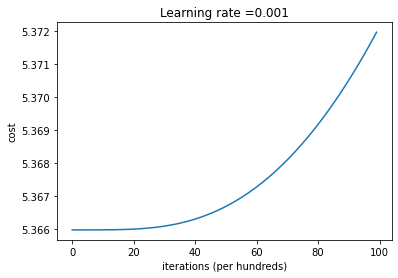

In [33]:
X = glass_X
Y = glass_y
label = glass_label
layers_dim = [9,6,6]
activation= 'sigmoid'
multiclass = True
parameters, costs = L_layer_model(X, Y, layers_dim, multiclass=True,  learning_rate = 0.001, num_iterations = 10000, plot= True)
y_hat = predict(X, parameters, multiclass=True)

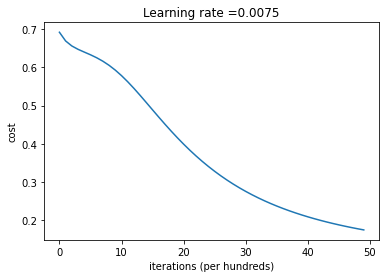

0.9670958512160229

In [34]:
X = bc_X
Y = bc_y
layers_dim = [9,3,1]
parameters, costs = L_layer_model(X, Y, layers_dim, learning_rate = 0.0075, num_iterations = 5000, plot= True)
y_hat = predict(X, parameters)
accuracy(Y.flatten(), y_hat.flatten())

In [35]:
X = glass_X
Y = glass_y
label = glass_label
layers_dim = [9,6,6]
activation= 'sigmoid'
multiclass = True
parameters, costs = L_layer_model(X, Y, layers_dim, multiclass=True,  learning_rate = 0.001, num_iterations = 100000, plot= False)
y_hat = predict(X, parameters, multiclass=True)
accuracy(label, y_hat.flatten())

0.5841121495327103

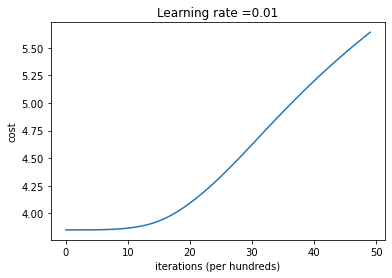

1.0

In [36]:
X = soybean_X
Y = soybean_y
label = soybean_label
layers_dim = [35,5,4]
parameters, costs = L_layer_model(X, Y, layers_dim, multiclass= True, learning_rate = 0.01, num_iterations = 5000, plot= True)
y_hat = predict(X, parameters, multiclass=True)
accuracy(label, y_hat.flatten())

##  CV Test

In [37]:
def NN_classification_CV_test(X, Y, label, layer_dim, multiclass = False, learning_rate= 0.005, num_iterations = 10000, k_fold = 5, plot = False):
    """
    Conduct Cross Validation for Logistic Regression 
    Input: X -- data of size (number of feature, number of examples)
           Y -- true "label" vector (0,1), or shape (number of classes, number of examples) for multiclass
           learning_rate : float, training speed regulator
           num_iterations : interation upperbound
           tol -- tolerance parameter, stopping criteria
    Output: Y_prediction :a vector containing all predictions (0/1) for binaray, classification for nulticlass
    """
    k_fold_idx, tuning_set = stratefied_cross_validation(label, k_fold)
    
    for i in range(k_fold):
        result = {'score':[], 'predictions':[],'cross_entropy':[]}
        train_idx, test_idx = k_fold_idx[i]
        train_X, test_X = X[:,train_idx], X[:,test_idx]
        train_y, test_y = Y[:,train_idx], Y[:,test_idx]       
            
        parameters, costs = L_layer_model(X= train_X, Y= train_y, layer_dim= layer_dim, learning_rate = learning_rate, num_iterations= num_iterations)
        y_hats = predict(X, parameters, multiclass = multiclass)
        score = accuracy(label.flatten(), y_hats.flatten())
        result['score'].append(score)
        result['predictions'].append(y_hats)
        result['cross_entropy'].append(costs)
        
        if plot:
            y = np.array(result['cross_entropy']).flatten()
            x = np.linspace(0, len(y)-1, len(y))
            plt.plot(x, y)
            plt.title('cross_entropy vs iteration')
            plt.xlabel('iteration (x100)')
            plt.ylabel('cross_entropy')
    print('k-fold average:', np.mean(result['score']))
    return result

k-fold average: 0.9713876967095851


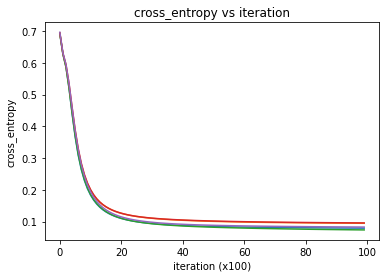

In [38]:
X = bc_X
Y = bc_y
label = bc_y.flatten()
layer_dim = [9,5,1]
result = NN_classification_CV_test(X, Y, label, layer_dim, multiclass = False, learning_rate= 0.03, num_iterations = 10000, plot= True, k_fold = 5) 

k-fold average: 0.46261682242990654


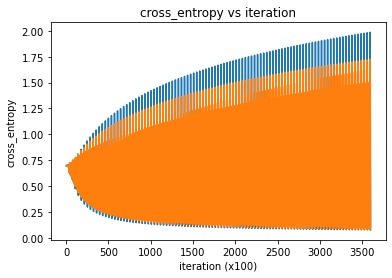

In [39]:
X = glass_X
Y = glass_y
label = glass_label
layer_dim = [9,6]
result = NN_classification_CV_test(X, Y, label, layer_dim, multiclass = True, learning_rate= 0.005, num_iterations = 10000, plot= True, k_fold = 2) 

In [40]:
result['cross_entropy'][0][0].shape

(6, 6)

k-fold average: 1.0


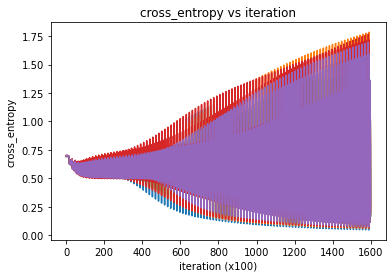

In [41]:
X = soybean_X
Y = soybean_y
label = np.array(soybean_label)
layer_dim = [35,5,4]
result = NN_classification_CV_test(X, Y, label, layer_dim, multiclass = True, learning_rate= 0.01, num_iterations = 10000, plot= True, k_fold = 5) 

## Param tuning

In [42]:
def param_tuning(X, Y, label = None, learning_rate= [0.01], num_iterations = [10000], tol = [1e-5], plot= True):
    """
    This function is used to tune hyper parameters. 
    
    """
    
    if label is None:
        label = Y
    k_fold_idx, tuning_idx = stratefied_cross_validation(label)
    train_idx = np.concatenate((np.array(k_fold_idx[0][0]), np.array(k_fold_idx[0][1])))
    train_X, tuning_X = X[:,train_idx], X[:,tuning_idx]
    
    if len(Y.shape) ==1 or Y.shape[0]==1:
        train_y, tuning_y = expand_dims(Y[train_idx], axis = 0), expand_dims(Y[tuning_idx], axis = 0)
    else:
        train_y, tuning_y = Y[:,train_idx], Y[:,tuning_idx]
        
    result = {'score':[], 'predictions':[],'cross_entropy':[]}
    ParamList = [learning_rate, num_iterations, tol]
    param = ParamList[np.argmax([len(learning_rate), len(num_iterations), len(tol)])]
    
    counter = 0
    for lr in learning_rate:
        for t in tol:
            for num_iter in num_iterations:
                score, Y_prediction, cross_entropy, model = LogisticRegression(X= train_X, Y= train_y, test_X = tuning_X, test_y = tuning_y, learning_rate = lr, num_iterations= num_iter, tol =t)
                result['score'].append(score)
                result['predictions'].append(Y_prediction)
                result['cross_entropy'].append(cross_entropy)
                counter +=1
    if plot:
        x = [p for p in param]
        y = result['score']
        plt.plot(x, y)
        plt.title('score vs hyperparamter')
        plt.xlabel(str(param))
        plt.ylabel('score')
    
    return result
    